In [20]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from skbio.stats.composition import (closure, perturb, power, ilr, ilr_inv,
                                     inner, perturb_inv, clr, clr_inv, centralize)
from skbio.diversity.beta import weighted_unifrac
from skbio import TreeNode
from skbio import OrdinationResults
from skbio.stats.ordination import ca, pcoa
from gneiss.util import rename_internal_nodes, match
from gneiss.sort import niche_sort, mean_niche_estimator
import scipy
import ternary
from skbio.stats.composition import (closure, perturb, power, ilr, ilr_inv, 
                                     inner, perturb_inv, clr, centralize)
from skbio.diversity.beta import weighted_unifrac
from skbio import TreeNode, DistanceMatrix

from scipy.cluster.hierarchy import average
from scipy.spatial.distance import euclidean
from biom import load_table
import seaborn as sns
from matplotlib.gridspec import GridSpec
from matplotlib import cm
import random
from ete3 import Tree, TreeStyle, NodeStyle, faces, AttrFace, CircleFace, BarChartFace
from collections import OrderedDict

from skbio.diversity import beta_diversity

%matplotlib inline

In [2]:
def convert_biom_to_pandas(table):
    """ Unpacks biom table into two pandas dataframes.
    
    The first dataframe will contain the count information for 
    features and samples. The second datafram will contain taxonomy 
    information for all of the OTUs.
    
    Parameters
    ----------
    table : biom.Table
    
    Returns
    -------
    pd.DataFrame
        Contingency table of counts where samples correspond 
        to rows and columns correspond to features (i.e. OTUs)
    pd.DataFrame
        A mapping of OTU names to taxonomic ids
    """

    feature_table = pd.DataFrame(np.array(table.matrix_data.todense()).T,
                             index=table.ids(axis='sample'),
                             columns=table.ids(axis='observation'))
    feature_ids = table.ids(axis='observation')
    mapping = {i: table.metadata(id=i, axis='observation')['taxonomy'] for i in feature_ids}
    # modify below as necessary.  
    # There are typically 7 levels of taxonomy.
    taxonomy = pd.DataFrame(mapping, 
                            index=['kingdom', 'phylum', 'class', 'order', 
                                   'family', 'genus', 'species']).T
    return feature_table, taxonomy

In [3]:
mapping = pd.read_table('../data/88soils/103_prep_568_qiime_20150818-225427.txt', index_col=0)
table = load_table('../data/88soils/238_otu_table.biom')

In [4]:
read_filter = lambda val, id_, md: sum(val) > 100
family_filter = lambda id_, x: x['taxonomy'][5]
table.filter(read_filter, axis='sample') 
table.filter(read_filter, axis='observation')

116 x 88 <class 'biom.table.Table'> with 3411 nonzero entries (33% dense)

In [5]:
otu_table, taxonomy = convert_biom_to_pandas(table)
otu_table, mapping = match(otu_table, mapping)

In [6]:
otu_table = niche_sort(otu_table, mapping.ph)

In [7]:
f = lambda x: mean_niche_estimator(x, mapping.ph)
mean_ph = otu_table.apply(f)
df = pd.merge(taxonomy, pd.DataFrame({'mean_ph':mean_ph}), left_index=True, right_index=True)
df.to_csv('../results/88soils_sorted_table.txt', sep='\t')

In [ ]:
otu_table, mapping = match(otu_table, mapping)

sns.set_style("white")

ord_res = ca(otu_table)
perc_explained = ord_res.eigvals / ord_res.eigvals.sum()

In [ ]:
b = np.argmin(mapping.ph)
fit = plt.figure(figsize=(10, 10))
f = lambda x: euclidean(x.values, ord_res.samples.loc[b].values)
distances = ord_res.samples.apply(f, axis=1)

a, b, _, _, _ = scipy.stats.linregress(mapping.ph, np.exp(distances))
x = np.linspace(min(mapping.ph), max(mapping.ph), 100)
predict = a * x + b

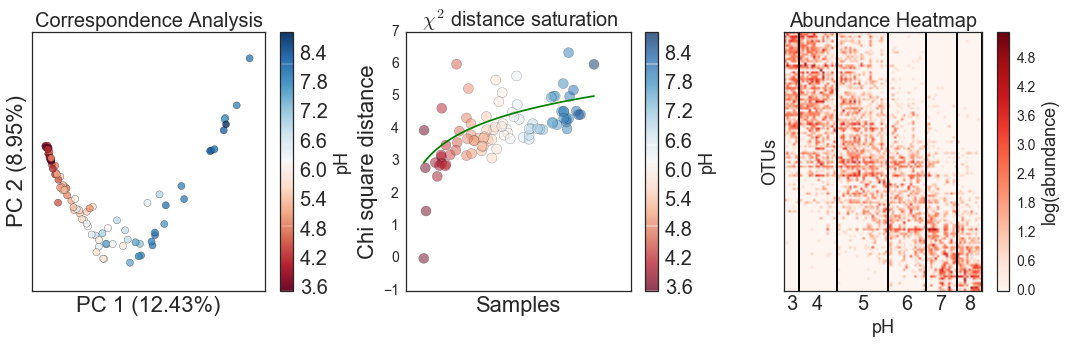

In [43]:
fig = plt.figure(figsize=(20, 5))
gs = GridSpec(100, 100, bottom=0.18,left=0.18,right=0.88)

ax1 = fig.add_subplot(gs[:, :29])
ax2 = fig.add_subplot(gs[:, 37:65])
ax3 = fig.add_subplot(gs[:, 71:])
sns.set_style('white')

## Plot 1
im = ax1.scatter(ord_res.samples['CA1'], ord_res.samples['CA2'],
                 c=mapping.ph, cmap=plt.cm.RdBu, s=50, alpha=0.8)
ax1.set_xlabel('PC 1 ({:.2%})'.format(perc_explained[0]), fontsize=22)
ax1.set_ylabel('PC 2 ({:.2%})'.format(perc_explained[1]), fontsize=22)
ax1.set_title('Correspondence Analysis', fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label('pH', fontsize=18)
cbar.ax.tick_params(labelsize=20)


## Plot 2
im = ax2.scatter(mapping.ph, distances,  
                 c=mapping.ph, cmap=plt.cm.RdBu, alpha=0.5, s=100)
ax2.plot(x, np.log(predict), '-g')
ax2.set_title(' $\chi^2$ distance saturation', fontsize=20)
ax2.set_xticks([])

ax2.set_xlabel('Samples', fontsize=22)
ax2.set_ylabel('Chi square distance', fontsize=22)
cbar = fig.colorbar(im, ax=ax2)
cbar.set_label('pH', fontsize=18)
cbar.ax.tick_params(labelsize=20)
ax2.tick_params(labelsize=14)

## Plot 3
otu_table, mapping = match(otu_table, mapping)
otu_table = niche_sort(otu_table, mapping.ph)
im = ax3.imshow(np.log(otu_table+1).T, cmap=plt.cm.Reds)
ax3.set_yticks([])
ax3.set_ylabel('OTUs', fontsize=18)
ax3.set_xlabel('pH', fontsize=18)

ticks = mapping.ph.apply(int).value_counts().sort_index().cumsum()
midpoints = ticks - (ticks - np.array([0] + list(ticks.values[:-1]))) / 2.0
ax3.set_xticks(ticks.values, minor=False)
ax3.set_xticks(midpoints, minor=True)

ax3.set_xticklabels(ticks.index, fontsize=20, minor=True)
ax3.set_xticklabels([], fontsize=20, minor=False)
ax3.grid(which='major', color='k', linestyle='-', linewidth=2)

cbar = fig.colorbar(im, ax=ax3)
cbar.set_label('log(abundance)', fontsize=18)
cbar.ax.tick_params(labelsize=14)
ax3.set_title('Abundance Heatmap', fontsize=20)
fig.savefig('../results/88soils.pdf')